In [11]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import preprocess_input

In [ ]:
import os
import cv2
from collections import Counter


def analyze_image_sizes(directory):
    image_sizes = []
    
    
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'tiff')):
                image_path = os.path.join(root, file)
                
               
                img = cv2.imread(image_path)
                
                if img is not None:
                   
                    height, width = img.shape[:2]
                    image_sizes.append((width, height))
    

    if not image_sizes:
        print(f"No valid images found in {directory}.")
        return None
 
    widths, heights = zip(*image_sizes)
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    

    size_distribution = Counter(image_sizes)

    metrics = {
        'total_images': len(image_sizes),
        'average_width': avg_width,
        'average_height': avg_height,
        'size_distribution': size_distribution
    }


    print(f"Total Images: {metrics['total_images']}")
    print(f"Average Width: {metrics['average_width']:.2f}")
    print(f"Average Height: {metrics['average_height']:.2f}")
    print(f"Most Common Sizes:")
    for size, count in metrics['size_distribution'].most_common(5):
        print(f"  {size}: {count} images")

    return metrics


dataset_directory = '/kaggle/input/dataset/dataset'
analyze_image_sizes(dataset_directory)

In [12]:
datagen = ImageDataGenerator(validation_split = 0.2,
    rescale=1./255,  
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)


train_generator = datagen.flow_from_directory(
    '/kaggle/input/dataset/dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training'
)
test_generator = datagen.flow_from_directory(
    '/kaggle/input/dataset/dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
    
)
print(train_generator.class_indices)

Found 20722 images belonging to 8 classes.
Found 5177 images belonging to 8 classes.
{'0': 0, '130': 1, '180': 2, '230': 3, '270': 4, '320': 5, '40': 6, '90': 7}


In [14]:

weights_path = '/kaggle/input/mobilevnet/keras/default/1/mobilenet_1_0_224_tf_no_top.h5'

base_model = MobileNet(weights=weights_path, include_top=False, input_shape=(224, 224, 3), alpha=1.0)


x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(8, activation='softmax')(x)  # 8 car angle classes


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import os


checkpoint_dir = '/kaggle/working/model_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.keras'),  
    monitor='val_accuracy', 
    save_best_only=True,  
    save_weights_only=False,  
    mode='max',  
    verbose=1
)


early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=5, 
    restore_best_weights=True,  
    verbose=1
)


tensorboard_callback = TensorBoard(
    log_dir='/kaggle/working/logs',  
    histogram_freq=1,  
    write_graph=True,  
    write_images=False  
)



In [16]:
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
    

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples //test_generator.batch_size,
    epochs=15,
    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback],
    shuffle=True
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7454 - loss: 0.8642

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.93284, saving model to /kaggle/working/model_checkpoints/model_epoch_01_val_acc_0.93.keras
647/647 ━━━━━━━━━━━━━━━━━━━━ 864s 1s/step - accuracy: 0.7456 - loss: 0.8636 - val_accuracy: 0.9328 - val_loss: 0.2117
Epoch 2/15
  1/647 ━━━━━━━━━━━━━━━━━━━━ 8:57 832ms/step - accuracy: 0.8750 - loss: 0.2296

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.93284 to 0.96000, saving model to /kaggle/working/model_checkpoints/model_epoch_02_val_acc_0.96.keras
647/647 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8750 - loss: 0.2296 - val_accuracy: 0.9600 - val_loss: 0.1729
Epoch 3/15
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9013 - loss: 0.3061
Epoch 3: val_accuracy did not improve from 0.96000
647/647 ━━━━━━━━━━━━━━━━━━━━ 848s 1s/step - accuracy: 0.9013 - loss: 0.3061 - val_accuracy: 0.9369 - val_loss: 0.1926
Epoch 4/15
  1/647 ━━━━━━━━━━━━━━━━━━━━ 9:00 837ms/step - accuracy: 0.9688 - loss: 0.1831
Epoch 4: val_accuracy did not improve from 0.96000
647/647 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9688 - loss: 0.1831 - val_accuracy: 0.8000 - val_loss: 0.8319
Epoch 5/15
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9167 - loss: 0.2696
Epoch 5: val_accuracy did not improve from 0.96000
647/647 ━━━━━━━━━━━━━━━━━━━━ 875s 1s/step - accuracy: 0.9167 - loss: 0.2696 - val_accuracy: 0.

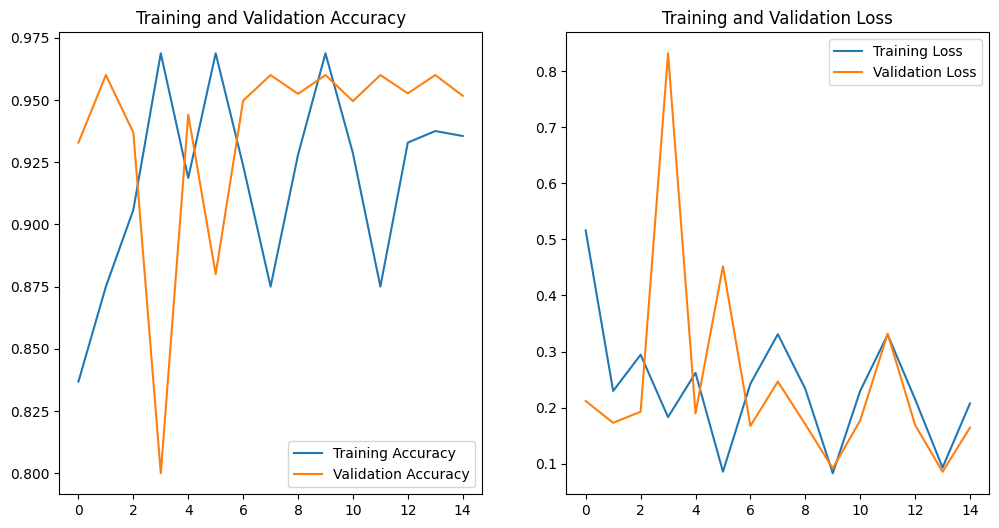

In [18]:
import matplotlib.pyplot as plt


def plot_accuracy_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

# Call this function after training
plot_accuracy_and_loss(history)

162/162 ━━━━━━━━━━━━━━━━━━━━ 153s 940ms/step


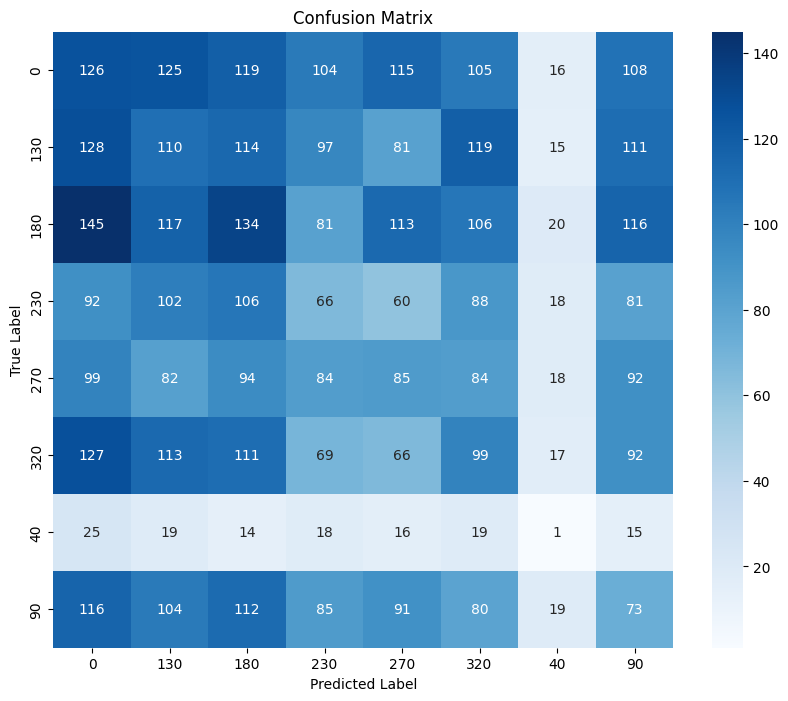

Classification Report
              precision    recall  f1-score   support

           0       0.15      0.15      0.15       818
         130       0.14      0.14      0.14       775
         180       0.17      0.16      0.16       832
         230       0.11      0.11      0.11       613
         270       0.14      0.13      0.13       638
         320       0.14      0.14      0.14       694
          40       0.01      0.01      0.01       127
          90       0.11      0.11      0.11       680

    accuracy                           0.13      5177
   macro avg       0.12      0.12      0.12      5177
weighted avg       0.13      0.13      0.13      5177



In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate predictions on the test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
true_labels = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(true_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print('Classification Report')
target_names = list(test_generator.class_indices.keys())
print(classification_report(true_labels, y_pred, target_names=target_names))